This notebook has the model which considers the neighborhood information of the pixel by implementing the CNN approach.

---



In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import random
import math

In [0]:
def make_image(output, shape):
    images = np.reshape(output, shape)
    plt.figure()
    plt.imshow(images)

In [0]:
def convert_output_image(img_flattened, img_shape):
  cols = img_flattened.shape[1]
  img = np.full((img_shape[0], img_shape[1], img_shape[2]), None, dtype = "float")
  for i in range(cols):
    row = math.floor(i/img_shape[1])
    col = i % img_shape[1]
    img[row, col, :] = img_flattened[:, i]
  return img

In [0]:
class NeuralNetwork:
    def __init__(self, x, y, num_hidden, epochs,batch_epochs, learning_rate, num_nodes_layers, activation_function, batch_size):
        self.x = x
        self.y = y

        self.n_x = x[0].shape[0]
        self.n_out = y[0].shape[0]

        self.batch_size = batch_size
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_epochs = batch_epochs
        self.num_hidden = num_hidden
        self.num_layers = num_hidden + 1 

        self.num_nodes_layers = num_nodes_layers
        # inserting input and output nodes to the list
        self.num_nodes_layers.insert(0, self.n_x)
        self.num_nodes_layers.append(self.n_out)

        self.leaky_slope = 0.01
        self.weights = []
        self.bias = []

    # parameters: weight and bias
    # weight[l] : (num_layers * num_layers-1 ) * num_layers : (no. of nodes in layer l * no. of nodes in layer (l-1)) * no. of layers
    # bias[l]: () : ( no. of nodes in layer * 1) * no. of layers
    def initialize_parameters_random(self):
        for l in range(1, self.num_layers + 1):
            self.weights.append(
                np.random.rand(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Use this when activation function is tanh or sigmoid
    def initialize_parameters_xavier(self):

        for l in range(1, self.num_layers + 1):
            # print("l =", l)
            # print(self.num_nodes_layers[l] , self.num_nodes_layers[l-1])
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                1 / self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Use this when activation function is ReLU or Leaky ReLu
    def initialize_parameters_he(self):
        for l in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                2 / self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Activation Functions
    def activation(self, x):
        if self.activation_function == "linear":
            return x
        if self.activation_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation_function == "tanh":
            return np.tanh(x)
        elif self.activation_function == "relu":
            a = np.zeros_like(x)
            return np.maximum(a, x)
        elif self.activation_function == "leaky_relu":
            a = self.leaky_slope * x
            return np.maximum(a, x)

    def gradient_activation(self, X):
        if self.activation_function == "linear":
            return np.ones_like(X)
        elif self.activation_function == "sigmoid":
            return self.activation(X) * (1 - self.activation(X))
        elif self.activation_function == "tanh":
            return (1 - np.square(X))
        elif self.activation_function == "relu":
            grad = np.zeros_like(X)
            grad[X > 0] = 1.0
            return grad
        elif self.activation_function == "leaky_relu":
            grad = np.ones_like(X)
            grad[X <= 0] = self.leaky_slope
            return grad

    def forward_propogation(self, x):
        # dim of A vector: (no. of hidden nodes * num_data) *(no. of layers)
        A = []
        Z = []
        A.append(x)
        A_prev = x

        for l in range(0, self.num_layers):
            z = np.matmul(self.weights[l], A_prev)
            a = self.activation(z)
            A_prev = a
            A.append(a)
            Z.append(z)
        return (A, Z)


    def loss_function(self, y, out):
        return (0.5 * np.sum((y - out) ** 2))

    def back_propogation(self, A, Z, y):

        delta_z = [None for i in range(self.num_layers)]
        delta_weight = [None for i in range(self.num_layers)]

        delta_z[-1] = np.multiply((y - A[-1]), self.gradient_activation(Z[-1]))
        delta_weight[-1] = np.matmul(delta_z[-1], A[-2].T)

        for l in range(self.num_layers - 2, -1, -1):
            delta_z[l] = np.multiply(np.matmul(self.weights[l + 1].T, delta_z[l + 1]), self.gradient_activation(Z[l]) )
            delta_weight[l] = np.matmul( delta_z[l], A[l].T )

        return delta_weight

    def update_weight(self, A, delta_weight):
        # weight = weight + learning_rate * error * input
        m = A[-1].shape[1]
        for l in range(self.num_layers):
            self.weights[l] = self.weights[l] + (self.learning_rate * delta_weight[l])/m

    def predict(self, x_test):
        A,Z = self.forward_propogation(x_test)
        prediction = A[-1]

        return prediction


    def model(self):

        # initializing parameters
        if (self.activation_function in ["tanh", "sigmoid"]):
            self.initialize_parameters_random()
        elif (self.activation_function in ["relu", "leaky_relu"]):
            self.initialize_parameters_random()
        else:
            self.initialize_parameters_random()


        for e in range(self.epochs):

            loss = []
            n_images = len(self.x) 
            for j in range(n_images):
                x = self.x[j]
                y = self.y[j]

                A, Z = self.forward_propogation(x)     
                delta_weight = self.back_propogation(A, Z, y)
                self.update_weight(A, delta_weight)

                prediction = self.predict(x)
                loss.append(self.loss_function(prediction*255, y*255))
                
            if e%10 == 0:
                print("Epoch = ", e)
                print("loss = ", np.mean(loss))

In [0]:
def image_to_grayscale(input_image):

    r = input_image[:,:,0]
    g = input_image[:,:,1]
    b = image_image[:,:,2]

    grayscale_image = 0.21*r + 0.72*g + 0.07*b
    grayscale_image = np.asarray(grayscale_image)
    return grayscale_image

In [0]:
def image_to_batch(img, window_size = 5, stride = 1):

    gray = image_to_grayscale(img)

    padding = int((window_size - 1)/2)
    padded_img = np.zeros((2 * padding + gray.shape[0], 2 * padding + gray.shape[1]))
    padded_img[padding:-padding,padding:-padding] = gray

    rows = gray.shape[0]
    cols = gray.shape[1]
    input_batch = []
    output_batch = []
    for i in range(0,rows,stride):
        for j in range(0,cols,stride):
            window = padded_img[i:i+window_size,j:j+window_size]
            input_batch.append(window.flatten())
            output_batch.append(img[i,j,:])
    input_batch = np.asarray(input_batch).T
    output_batch = np.asarray(output_batch).T

    return input_batch, output_batch

In [0]:
def split_data(images, window_size = 5, stride = 1):

    train_data = []
    train_output = []
    test_data = []
    test_output = []

    for img in images:
        input_batch, output_batch = image_to_batch(img, window_size, stride)

        choice = random.random()
        if choice < 0.85:
            train_data.append(input_batch)
            train_output.append(output_batch)
        else:
            test_data.append(input_batch)
            test_output.append(output_batch)

    return (train_data, train_output), (test_data, test_output)

In [0]:
def get_data(directory_in_str):
    images = []
    directory = os.fsencode(directory_in_str)
    count = 1

    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        filename = os.fsdecode(path)

        img = mpimg.imread(filename)
        images.append(np.asarray(img))
        count+=1

    return images

6
2
Epoch =  0
loss =  1236635133.825226
Epoch =  10
loss =  352360683.34787744
Epoch =  20
loss =  352307829.1267223
Epoch =  30
loss =  352251377.73494804
Epoch =  40
loss =  352187377.2726693
Epoch =  50
loss =  352114002.06263024
Epoch =  60
loss =  352028793.8434496
Epoch =  70
loss =  351928362.21590185
Epoch =  80
loss =  351807901.12543786
Epoch =  90
loss =  351660379.64656776
Epoch =  100
loss =  351475132.5626522
Epoch =  110
loss =  351235298.6566708
Epoch =  120
loss =  350912966.35256195
Epoch =  130
loss =  350459704.71193033
Epoch =  140
loss =  349788548.9285297
Epoch =  150
loss =  348748072.5112888
Epoch =  160
loss =  347150124.097387
Epoch =  170
loss =  345121448.92545885
Epoch =  180
loss =  343372284.53987235
Epoch =  190
loss =  342014803.3656929
Epoch =  200
loss =  340732276.3731174
Epoch =  210
loss =  339416053.50985867
Epoch =  220
loss =  338033973.82971436
Epoch =  230
loss =  336559585.03026325
Epoch =  240
loss =  334958881.6182011
Epoch =  250
loss = 

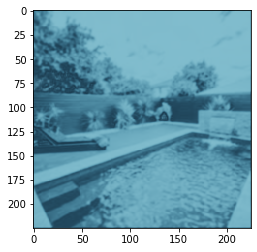

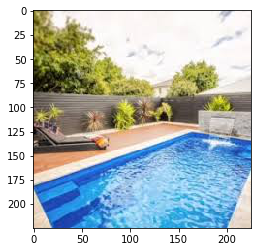

[[0.16691552 0.18419393 0.15513503 ... 0.16057602 0.16036949 0.14230976]
 [0.34411746 0.37457317 0.32284975 ... 0.33622503 0.33587267 0.30079078]
 [0.43496128 0.46787033 0.41148488 ... 0.42684187 0.42645783 0.38702935]]


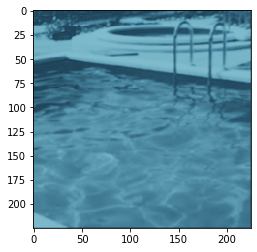

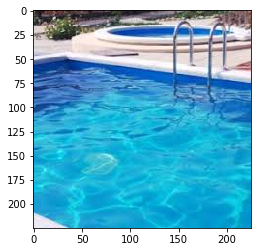

In [0]:
if __name__ == "__main__":
    import os

    THIS_FOLDER = os.path.dirname("D:/Rushabh/MS/College/Sem 1/520 - Intro to AI/Projects/Colorizer/NN.ipynb")
    my_file = os.path.join(THIS_FOLDER, 'Google data classes/water')
    images = get_data(my_file)

    (x_train, y_train), (test_data, test_output) = split_data(images, 3)
    print(len(x_train))
    print(len(test_data))

    for i in range(len(x_train)):
        x_train[i] = x_train[i]/255.0
        y_train[i] = y_train[i]/255.0
    
    nn = NeuralNetwork(x_train, y_train, num_hidden= 2, epochs= 500, batch_epochs = 1, learning_rate=1, num_nodes_layers=[16, 9],
                       activation_function="sigmoid", batch_size = 1)
    nn.model()
    
    count = 1
    for test_img, test_out in zip(test_data, test_output):
        test_img = test_img/255.0
        test_out = test_out/255.0
        prediction = nn.predict(test_img)
        print(prediction)
        img = convert_output_image(prediction, images[-1].shape)
        plt.figure()
        plt.imshow(img)
        plt.imsave("D:/Rushabh/MS/College/Sem 1/520 - Intro to AI/Projects/Colorizer/CNN_out/Colored_" + str(count) + ".jpg", img)

        # Actual Image
        img = convert_output_image(test_out, images[-1].shape)
        plt.figure()
        plt.imshow(img)
        plt.imsave("D:/Rushabh/MS/College/Sem 1/520 - Intro to AI/Projects/Colorizer/CNN_out/Original_" + str(count) + ".jpg", img)
        plt.show()
        count += 1